In [73]:
# This code is a recreation of the original tube making code in Python. 
# The input is a magno video and the output is a list of tubes and an output video with tubes overlaid.
# Here, we break the output up into "stages," which build upon each other 


# Necessary inputs
import cv2
import numpy as np
import argparse
import csv
import os
import math
import random
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.cluster import DBSCAN
from copy import deepcopy
from operator import itemgetter
from itertools import *


In [74]:
# Useful Functions
def make_ellipse(image, row):
    center = (int(round(row[0])),int(round(row[1])))
    axes = (int(round(row[2])*2 ),int(round(row[3])*2) )
    angle = int(round(row[4]))
    color = (row[8],row[9],row[10])
    thickness = 4  #Do -1 if you want it filled in

    return cv2.ellipse(image, center, axes, angle, 0, 360, color, thickness) 

def make_ellipse2(image, ellipse):
    thickness = 4  #Do -1 if you want it filled in
    
    return cv2.ellipse(image, ellipse[1], ellipse[3], thickness) 

def make_ellipse3(image, ellipse,tubenum):
    thickness = 4  #Do -1 if you want it filled in
    center = (int(ellipse[0][1][0][0]), int(ellipse[0][1][0][1]) )
    
    cv2.putText(image,str(tubenum), center,cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), thickness)
    return cv2.ellipse(image, ellipse[0][1], ellipse[0][3], thickness) 

def draw_event(image, event):
    thickness = 4
    center = (int(event[2]), int(event[4]) )
    
    return cv2.putText(image,"X", center,cv2.FONT_HERSHEY_PLAIN, 4, (0,0,255), thickness)
    
def writevid(vid, outvidpath):
     #Look at imageshape output and take size from there (reversed)
    H = vid[1].shape[0]
    W = vid[1].shape[1]
    numframes = len(vid)
    vidwriter = cv2.VideoWriter(outvidpath, cv2.VideoWriter_fourcc(*'MP4V'),10, (W, H))

    for i in range(1, numframes):
        if i%50==0:
            print("FRAME" , i, "/", numframes)        
        vidwriter.write(vid[i])
               
    vidwriter.release()
    cv2.destroyAllWindows()
    
def readvid(vidinfile):
    #Read in video at vidinfile
    vidcap = cv2.VideoCapture(vidinfile) 
    thevid = []
    F=0
    while(vidcap.isOpened()):
        ret, frame = vidcap.read()
        if ret == False:
            break
        else:
            F=F+1
            thevid.append(frame)

    vidcap.release()
    cv2.destroyAllWindows()
    print(type(thevid))
    return thevid

def putTracksOnVid(tracks, vidinfile, vidoutfile):

    vidcap = cv2.VideoCapture(vidinfile) 
    inputvid = []
    F=0
    
    #Read in video at vidinfile
    while(vidcap.isOpened()):
        ret, frame = vidcap.read()
        if ret == False:
            break
        else:
            F=F+1
            inputvid.append(frame)

    vidcap.release()
    cv2.destroyAllWindows()

    #Put the red rectangles on the vid for the tracks
    outvid = deepcopy(inputvid)
    for f in range(1,len(outvid)):
        here = []
        for T in tracks:
            here.extend([t for t in T if t[0]==f])
        if here: #if any track has a box on this frame
            for h in here:
                bbox = h[1]
                p1 = (int(bbox[0]), int(bbox[1]))
                p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
                cv2.rectangle(outvid[f], p1, p2, (0,0,255), 2, 1) #red
            
    #Writes the output vid to a video file
    vidwriter = cv2.VideoWriter(vidoutfile, cv2.VideoWriter_fourcc(*'MP4V'),30, (W, H))
    for i in range(1, F):
        if i%100==0:
            print("FRAME" , i, "/", F)        
        vidwriter.write(outvid[i])
    vidwriter.release()
    cv2.destroyAllWindows()
    
def putMarksOnVid(marks, vidinfile, vidoutfile):

    vidcap = cv2.VideoCapture(vidinfile) 
    inputvid = []
    F=0
    
    #Read in video at vidinfile
    while(vidcap.isOpened()):
        ret, frame = vidcap.read()
        if ret == False:
            break
        else:
            F=F+1
            inputvid.append(frame)

    vidcap.release()
    cv2.destroyAllWindows()

    #Check score for mark and put proper thing on the vid 
    outvid = deepcopy(inputvid)
    for f in range(1,len(outvid)):
        here = []
        for T in marks:
            here.extend([t for t in T if t[0]==f])
        if here: #if any track has a box on this frame
            for h in here:
                bbox = h[1]
                p1 = (int(bbox[0]), int(bbox[1]))
                p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
                if h[2]==1:
                    #cv2.rectangle(outvid[f], p1, p2, (0,255,255), 2, 6) #yellow
                    continue
                elif h[2]==2:
                    cv2.rectangle(outvid[f], p1, p2, (0,0,255), 2, 10) #red
                else:
                    cv2.rectangle(outvid[f], p1, p2, (0,255,0), 2, 10) #green
            
    #Writes the output vid to a video file
    vidwriter = cv2.VideoWriter(vidoutfile, cv2.VideoWriter_fourcc(*'MP4V'),30, (W, H))
    for i in range(1, F):
        if i%100==0:
            print("FRAME" , i, "/", F)        
        vidwriter.write(outvid[i])
    vidwriter.release()
    cv2.destroyAllWindows()
    
    
def putTubesOnVid(tubevar, vidoutfile, withnums = False):
    
    if not withnums:
        #Draw the ellipses on the video to check...
        outvid = deepcopy(invid)
        for f in range(1,F):
            puthere = []

            for path in tubevar:
                P = [e for e in path if e[0]==f]
                puthere.extend(P)

            for ellipse in puthere:
                make_ellipse2(outvid[f],ellipse)

        #Writes the thresholded magno vid to a video file
        vidwriter = cv2.VideoWriter(vidoutfile, cv2.VideoWriter_fourcc(*'MP4V'),30, (W, H))
        for i in range(1, F):
            if i%100==0:
                print("FRAME" , i, "/", F)        
            vidwriter.write(outvid[i])
        vidwriter.release()
        cv2.destroyAllWindows()
    
    else:        
        #WITH NUMS    
        #Draw the ellipses on the video to check...
        outvid = deepcopy(invid)
        for f in range(1,F):
            puthere = []

            for path in tubevar:
                P = [e for e in path if e[0]==f]
                T = [tubevar.index(path) for e in path if e[0]==f]
                puthere.append([P,T])

            for [ellipse,Tnum] in puthere:
                if ellipse:
                    make_ellipse3(outvid[f],ellipse,Tnum)


        #Writes the thresholded magno vid to a video file
        vidwriter = cv2.VideoWriter(vidoutfile, cv2.VideoWriter_fourcc(*'MP4V'),30, (W, H))
        for i in range(1, F):
            if i%100==0:
                print("FRAME" , i, "/", F)        
            vidwriter.write(outvid[i])
        vidwriter.release()
        cv2.destroyAllWindows()


def putSomeTubesOnVid(tubevar, vidoutfile, which =[]):
    
    #WITH NUMS    
    #Draw the ellipses on the video to check...
    outvid = deepcopy(invid)
    selectedtubes = [tubevar[w] for w in which]
    
    for f in range(1,F):
        puthere = []

        for path in selectedtubes:
            P = [e for e in path if e[0]==f]
            T = [tubevar.index(path) for e in path if e[0]==f]
            puthere.append([P,T])

        for [ellipse,Tnum] in puthere:
            if ellipse:
                make_ellipse3(outvid[f],ellipse,Tnum)


    #Writes the thresholded magno vid to a video file
    vidwriter = cv2.VideoWriter(vidoutfile, cv2.VideoWriter_fourcc(*'MP4V'),30, (W, H))
    for i in range(1, F):
        if i%100==0:
            print("FRAME" , i, "/", F)        
        vidwriter.write(outvid[i])
    vidwriter.release()
    cv2.destroyAllWindows()

    
def putEventsOnVid(eventvar, vidinfile, vidoutfile):

    vidcap = cv2.VideoCapture(vidinfile) 
    inputvid = []
    F=0
    
    #Read in video at vidinfile
    while(vidcap.isOpened()):
        ret, frame = vidcap.read()
        if ret == False:
            break
        else:
            F=F+1
            inputvid.append(frame)

    vidcap.release()
    cv2.destroyAllWindows()

    #Draw the events on the video to get a visual
    outvid = deepcopy(inputvid)
    for f in range(1,F):
        puthere = [e for e in eventvar if (f>=e[0]) and (f<=e[1])]
        for event in puthere:
            draw_event(outvid[f],event)

    #Writes the output vid to a video file
    vidwriter = cv2.VideoWriter(vidoutfile, cv2.VideoWriter_fourcc(*'MP4V'),30, (W, H))
    for i in range(1, F):
        if i%100==0:
            print("FRAME" , i, "/", F)        
        vidwriter.write(outvid[i])
    vidwriter.release()
    cv2.destroyAllWindows()


In [155]:
# Stage 0: This stage shows the ellipses before any temporal associations are made. 
# We already filter out the smallest (<20 pix) ellipses before including them in our eList

vidbase = 'mot1'
inmagnovid = vidbase + '_magno.mp4'

vidcap = cv2.VideoCapture(inmagnovid) 
kernel = np.ones((10,10) , np.uint8)
magnovid = []
H=0
W=0
F=0

#Thresholds (at 50) the input magno video into a binary video 'magnovid'
while(vidcap.isOpened()):
    ret, frame = vidcap.read()
    if ret == False:
        break
    else:
        (dontcare, outframe) = cv2.threshold(frame, 50, 255, cv2.THRESH_BINARY)
        cv2.dilate(outframe,kernel, iterations =1)
        cv2.erode(outframe,kernel, iterations =1)
        H = frame.shape[0]
        W = frame.shape[1]
        F=F+1
        magnovid.append(outframe)

vidcap.release()
cv2.destroyAllWindows()


#Write the input video into a variable
invideo = vidbase + '.mp4'
vidcap = cv2.VideoCapture(invideo) 
invid = []
F2 = 0

while(vidcap.isOpened()):
    ret, frame = vidcap.read()
    if ret == False:
        break
    else:
        F2=F2+1
        invid.append(frame)
        
vidcap.release()
cv2.destroyAllWindows()
F = min(F,F2)

#Writes the thresholded magno vid to a video file
vidwriter = cv2.VideoWriter(vidbase +'_magnoOut.mp4', cv2.VideoWriter_fourcc(*'MP4V'),30, (W, H))
for i in range(1, F):
    if i%50==0:
        print("FRAME" , i, "/", F)        
    vidwriter.write(magnovid[i])
vidwriter.release()
cv2.destroyAllWindows()


#Each ellipse is put in the list as a tuple... (framenum, ellipse)
#Ellipse: (x,y) , (MAJORAXIS,minoraxis), angle
eList = []
for f in range(1,F): #for each frame
    M = cv2.cvtColor(magnovid[f], cv2.COLOR_BGR2GRAY);
    _, contours, hierarchy = cv2.findContours(M, 1, 2)
    
    for c in contours:
        if len(c) < 5:
            continue
        area = cv2.contourArea(c)
        if area < 100:
            continue
    
        ellipse = cv2.fitEllipse(c)
        eList.append( [f, ellipse, [0,0], [255,255,255] ] )
        
MAXS = np.asarray([max(e[1][1][0],e[1][1][1]) for e in eList if e[0] > 10])
MINS = np.asarray([min(e[1][1][0],e[1][1][1]) for e in eList if e[0] > 10])
AVGS = np.asarray([(e[1][1][0]+e[1][1][1])/2  for e in eList if e[0] > 10])

#Filtering the smallest ellipses (minsize for either dimension = 20pixels)



minsize =  .30 * np.mean(AVGS)
#minsize = 10
eList = [e for e in eList if (e[1][1][0] > minsize) and (e[1][1][1]>minsize)]



#Draw the ellipses on the video just to check...
magnotubes = deepcopy(invid)
for f in range(1,F):
    puthere = [e for e in eList if e[0]==f]
    
    for ellipse in puthere:
        make_ellipse2(magnotubes[f],ellipse)
        

#Writes the vid with tubes to a video file
vidwriter = cv2.VideoWriter(vidbase+'_outstage0NEWMINSIZE.mp4', cv2.VideoWriter_fourcc(*'MP4V'),30, (W, H))
for i in range(1, F):
    if i%100==0:
        print("FRAME" , i, "/", F)        
    vidwriter.write(magnotubes[i])
vidwriter.release()
cv2.destroyAllWindows()

FRAME 50 / 524
FRAME 100 / 524
FRAME 150 / 524
FRAME 200 / 524
FRAME 250 / 524
FRAME 300 / 524
FRAME 350 / 524
FRAME 400 / 524
FRAME 450 / 524
FRAME 500 / 524
FRAME 100 / 524
FRAME 200 / 524
FRAME 300 / 524
FRAME 400 / 524
FRAME 500 / 524


In [156]:
# Stage 1: We make the first swipe at temporal associations, turning ellipses into paths.

#Doing the first temporal associations. Should start to look like tubes
initialList = []
finalList = []
paths = [[]]
istart = 6
iend = istart+4
fstart = 11
fend = fstart+5
locthresh = 80
sizethresh = 50

while (fend < F):
    initialList = [e for e in eList if e[0]>=istart and e[0]<=iend]
    finalList =  [e for e in eList if e[0]>=fstart and e[0]<=fend]
    
    for ei in initialList:
        for ef in finalList:
            
            matchFlag = False
            r = math.sqrt((ef[1][0][0] - ei[1][0][0])**2 + (ef[1][0][1] - ei[1][0][1])**2 )
            sizediff = ef[1][1][1] - ei[1][1][1] #diff in major axis
            framediff = ef[0]-ei[0]
            
            if not(ei[2]==(0,0)):
                predX = ei[2][0]*framediff + ei[1][0][0]
                predY = ei[2][1]*framediff + ei[1][0][1]
                if (abs(predX-ef[1][0][0]) < 50) and (abs(predY-ef[1][0][1]) < 50):
                    matchFlag = True
            else:
                if (abs(sizediff)<sizethresh) and (r<locthresh):
                    matchFlag = True
            
            if (matchFlag):
                if ei[3]==[255,255,255]:
                    ei[3][0] = random.randint(0,255)
                    ei[3][1] = random.randint(0,255)
                    ei[3][2] = random.randint(0,255)
                ef[3][0] = ei[3][0]
                ef[3][1] = ei[3][1]
                ef[3][2] = ei[3][2]
                
                ef[2][0] = (ef[1][0][0]-ei[1][0][0])/framediff
                ef[2][1] = (ef[1][0][1]-ei[1][0][1])/framediff
                

                #This part searches for ei in existing paths and attaches ef if it finds it
                whichpath = 0
                for i in range(1,len(paths)): 
                    for ell in paths[i]:
                        if ei == ell:
                            whichpath = i
                            
                if not(whichpath==0):
                     paths[whichpath].append(ef)
                else:
                    newpath = []
                    newpath.append(ei)
                    newpath.append(ef)
                    paths.append(newpath)

    #print(fend)
    istart=istart+5
    iend=iend+5
    fstart=fstart+5
    fend=fend+5


    
stage1tubes = paths 
putTubesOnVid(paths, vidbase+'_outstage1.mp4')


FRAME 100 / 524
FRAME 200 / 524
FRAME 300 / 524
FRAME 400 / 524
FRAME 500 / 524


In [157]:
# Stage 2: If we have 2+ ellipses in the same path on the same frame, chose the larger one

#Fixes the paths so that each color corresponds to a path
newpaths=[[]]

for i in range(1,len(paths)):
    for e in paths[i]:
        RGB = e[3]
        makePathFlag = True
        
        for newpath in newpaths:
            if not newpath or not(newpath[0][3] == RGB):
                continue
            else:
                newpath.append(e)
                makePathFlag = False
                break
        
        if (makePathFlag):
            E = [e]
            newpaths.append(E)

            
#Gets rid of duplicates in each path (took forever smh)
K = deepcopy(newpaths)
newpaths = []

for i in range(0,len(K)):
    bigA = []
    for j in range(0,len(K[i])):
        thise = K[i][j]
        A = [K[i].index(e) for e in K[i] if e==thise]
        #print("A:", A)
        bigA.extend(A)
    
    out = [K[i][t] for t in list(set(bigA))]
    newpaths.append(out)

#Make sure newpaths is in frame order
for P in newpaths:
    P.sort(key = lambda x: x[0])
    


#Handles when there are 2 ellipses from the same tube on a single frame.
L = deepcopy(newpaths)

#toRemove = []

for i in range(0,len(L)):
    tubeSplits = []
    R = 2*np.mean(AVGS)
        
    for f in range(1,F):
        A = [e for e in L[i] if e[0] == f] #list of ellipses on this frame
        if len(A)>1:
            A.sort(key = lambda x: x[1][1][0]**2 + x[1][1][1]**2) 
            distList = [math.sqrt((a[1][0][0]-b[1][0][0])**2 + (a[1][0][1] - b[1][0][1])**2) for a in A for b in A if a!=b]
            if all(d>R for d in distList): #All the ellipses are far enough apart
                if not(tubeSplits):
                    tubeSplits = [[k] for k in A]
                    #collf = tubeSplits[0][0][0]
                    #toRemove.append([i,collf])
                else:
                    #ADD THINGS IN A TO TUBESPLITS ( [[e], [e]] ) APPROPRIATELY        
                    for a in A:
                        #check each distance and pick the smallest
                        dists = [math.sqrt((a[1][0][0]-tubeSplits[k][-1][1][0][0])**2 + (a[1][0][1] - tubeSplits[k][-1][1][0][1])**2) for k in range(0,len(tubeSplits))]
                        tubeSplits[dists.index(min(dists))].append(a)   
            
            else:
                L[i] = [e for e in L[i] if e not in A[:-1]] #get rid of the smaller one(s)
                
    #at the end of the tube
    if tubeSplits:
        if len(tubeSplits[0]) > 5 :
            print("Tube", i,"is getting snipped. TS length = ",len(tubeSplits[0]))
            L[i] = [e for e in L[i] if e[0] < tubeSplits[0][0][0]]

            for T in tubeSplits:
                RR = random.randint(0,255)
                G = random.randint(0,255)
                B = random.randint(0,255)
                for e in T:
                    e[3][0] = RR
                    e[3][1] = G
                    e[3][2] = B
                L.append(T)

#for tr in toRemove:
#    print("Deleting from", tr[0], "starting at ", tr[1])
#    print("Before", len(L[tr[0]]))
#    L[tr[0]] = [ell for ell in L[tr[0]] if ell[0] < tr[1]]
#    print("After", len(L[tr[0]]))
    
newpaths = L
stage2tubes = newpaths
putTubesOnVid(newpaths,vidbase+ '_outstage2.mp4')


Tube 145 is getting snipped. TS length =  6
Tube 238 is getting snipped. TS length =  15
Tube 253 is getting snipped. TS length =  7
FRAME 100 / 524
FRAME 200 / 524
FRAME 300 / 524
FRAME 400 / 524
FRAME 500 / 524


In [158]:
# Stage 3: Temporal filtering... Remove any path that isn't 20 frames or longer

L = deepcopy(newpaths)
temporalcutoff = 20
newpaths = [p for p in L if len(p)> temporalcutoff]          

    

stage3tubes = newpaths
putTubesOnVid(newpaths, vidbase+'_outstage3.mp4')

FRAME 100 / 524
FRAME 200 / 524
FRAME 300 / 524
FRAME 400 / 524
FRAME 500 / 524


In [159]:
# Stage 4: Officially turning paths into TUBES by filling in the temporal blanks

L = deepcopy(newpaths)
tubes = []

#Each slice should be [f, ((X,Y),(b,A),rot), [Vxavg,Vyavg], [R,G,B]]

for i in range(0,len(L)):
    slicestoAdd = []
    for f in range(L[i][0][0], L[i][-1][0]):
        #chunk = [L[i].index(e) for e in L[i] if abs(e[0]-f) < 15]
        
        thisone = [e for e in newpaths[1] if e[0]==f]
        if not thisone: #if we don't have a slice at this frame
            thischunk = []
            a = 2
            while len(thischunk) < 3:
                thischunk = [L[i].index(e) for e in L[i] if abs(e[0]-f)<=a]
                a=a+2
                
            chunkX = [L[i][ind][1][0][0] for ind in thischunk]
            X = sum(chunkX)/len(chunkX)
            chunkY = [L[i][ind][1][0][1] for ind in thischunk]
            Y = sum(chunkY)/len(chunkY)
            chunksmallax = [L[i][ind][1][1][0] for ind in thischunk]
            smallax=max(chunksmallax)
            chunkbigax = [L[i][ind][1][1][1] for ind in thischunk]
            bigax=max(chunkbigax)
            chunkphi = [L[i][ind][1][2] for ind in thischunk]
            phi=max(chunkphi)
            chunkf = [L[i][ind][0] for ind in thischunk]
            Vx = (chunkX[-1] - chunkX[0])/(max(chunkf)+1-min(chunkf))
            Vy = (chunkY[-1] - chunkY[0])/(max(chunkf)+1-min(chunkf))
        
            thisslice = [f, ((X,Y),(smallax,bigax),phi), [Vx,Vy], L[i][0][3]]
            slicestoAdd.append(thisslice)
            
    L[i].extend(slicestoAdd)
            
tubes = L


#Handles when there are 2 ellipses from the same tube on a single frame.
#We choose the bigger one
L = deepcopy(tubes)
tubes = []

for i in range(0,len(L)):
    toRemove = []
    for f in range(1,F):
        #build a list of shit to delete
        A = [e for e in L[i] if e[0] == f]
        if len(A)>1:
            A.sort(key = lambda x: x[1][1][0]**2 + x[1][1][1]**2) 
            toRemove.extend(A[:-1])

    tubes.append([p for p in L[i] if p not in toRemove])
    
#Sorting again... 
for t in tubes:
    t.sort(key = lambda x: x[0])
  

stage4tubes = tubes
putTubesOnVid(tubes, vidbase+'_outstage4.mp4')
putTubesOnVid(tubes, vidbase+'_outstage4nums.mp4', True)

FRAME 100 / 524
FRAME 200 / 524
FRAME 300 / 524
FRAME 400 / 524
FRAME 500 / 524
FRAME 100 / 524
FRAME 200 / 524
FRAME 300 / 524
FRAME 400 / 524
FRAME 500 / 524


In [160]:
# Tube merging functions to prepare us for the next stage(s)

def getMerges(L, lookahead):
    mergeList = []
    for i in range(0,len(L)):
        
            
        CVx = [L[i][ind][2][0] for ind in range(-5,0)]
        CVy = [L[i][ind][2][1] for ind in range(-5,0)]
        forVx = sum(CVx)/len(CVx)
        forVy = sum(CVy)/len(CVy)  #ending velocity of tube i
        BVx = [L[i][ind][2][0] for ind in range(0,5)]
        BVy = [L[i][ind][2][1] for ind in range(0,5)]
        backVx = sum(BVx)/len(BVx)
        backVy = sum(BVy)/len(BVy)  #starting velocity of tube i

        
        if len(L[i]) < 10:
            print("BAD")
            continue
        forX = [L[i][ind][1][0][0] for ind in range(-10,0)]
        forY = [L[i][ind][1][0][1] for ind in range(-10,0)]
        backX = [L[i][ind][1][0][0] for ind in range(0,10)]
        backY = [L[i][ind][1][0][1] for ind in range(0,10)]
        
        forVx = (forX[-1] - forX[0]) /10
        forVy = (forY[-1] - forY[0]) /10
        backVx = (backX[-1] - backX[0]) /10
        backVy = (backY[-1] - backY[0]) /10

        predx = (sum(forX)/len(forX)) + (forVx*lookahead)
        predy = (sum(forY)/len(forY)) + (forVy*lookahead)
        predf = L[i][-1][0] + lookahead
        backpredx = (sum(backX)/len(backX)) - (backVx*lookahead)
        backpredy = (sum(backY)/len(backY)) - (backVy*lookahead)
        backpredf = L[i][0][0] - lookahead

        for j in range(0,len(L)):
            if i==j:
                continue

            closeones = [e for e in L[j] if abs(e[0] - predf)<5]
            Bcloseones= [e for e in L[j] if abs(e[0]-backpredf)<5]
            matchFlag = False
            BmatchFlag= False

            for e in closeones:
                r = math.sqrt((e[1][0][0] - predx)**2 + (e[1][0][1] - predy)**2 )
                if (r<100) and (abs(e[2][0] - forVx)<2) and (abs(e[2][1] - forVy)<2):
                    matchFlag = True

            for e in Bcloseones:
                r = math.sqrt((e[1][0][0] - backpredx)**2 + (e[1][0][1] - backpredy)**2 )
                if (r<50) and (abs(e[2][0] - backVx)<2) and (abs(e[2][1] - backVy)<2):
                    BmatchFlag = True

            if (matchFlag):
                mergeList.append([i,j,0])  #j goes in back of i
            if (BmatchFlag):
                mergeList.append([i,j,1])  #j goes in front of i

    nahList = []
    for m in mergeList:
        a = m[0]
        b = m[1]
        
        allVxa = [L[a][ind][2][0] for ind in range(0,len(L[a])) ] 
        Vxa = sum(allVxa)/len(allVxa)
        allVya = [L[a][ind][2][1] for ind in range(0,len(L[a])) ] 
        Vya = sum(allVya)/len(allVya)  

        allVxb = [L[b][ind][2][0] for ind in range(0,len(L[b])) ] 
        Vxb = sum(allVxb)/len(allVxb)
        allVyb = [L[b][ind][2][1] for ind in range(0,len(L[b])) ] 
        Vyb = sum(allVyb)/len(allVyb)

        if (Vxa/Vxb>0) and (Vya/Vyb>0 or (abs(Vya)<1.2 and abs(Vyb)<1.2) ) :
            A = [L[a][ind][0] for ind in range(0,len(L[a]))]
            B = [L[b][ind][0] for ind in range(0,len(L[b]))]
            overlap = [val for val in A if val in B]
            if len(overlap) > min(len(A),len(B))/4:
                nahList.append(m)
        else:
            nahList.append(m)

    mergeList = [m for m in mergeList if m not in nahList]
    
    return mergeList

def doMerge(L, mergeList):
    
    colorList = [t[0][3] for t in L]
    for m in mergeList:
        tlist = []
        for i in range(0,len(L)):
            for e in L[i]:
                if e[3]==colorList[m[0]] or e[3]==colorList[m[1]]:
                    tlist.append(i)

        flattubes = [ell for tube in L for ell in tube]
        cList = [colorList[a] for a in set(tlist)]
        connected = [e for e in flattubes if e[3] in cList]
        for i in set(tlist):
            L[i] = connected
    
    #Remove the extras (duplicates)
    delList = []
    for i in range(0,len(L)):
        if not(L.index(L[i]) == i):
            delList.append(i)
            
    print(delList)
    Otubes = [L[i] for i in range(0,len(L)) if i not in delList ]
    
    for t in Otubes:
        for e in t:
            e[3] = t[0][3]
    

    return Otubes


In [161]:
# Stage 5: Merging tubes! This first merge is a short term merge (lookahead = 5 frames)

#Sorting again... 
for t in tubes:
    t.sort(key = lambda x: x[0])
    
#Readjusting the velocities based on a sliding window
L = deepcopy(tubes)
Vgap = 10 #calculating velocities across +/- Vgap 
for t in L:
    for i in range(0,len(t)): #for each ellipse
        close = [e for e in t if abs(e[0] - t[i][0])<= Vgap]
        starter = close[0]
        ender = close[-1]
        fgap = ender[0]-starter[0]
        Vx = (ender[1][0][0] - starter[1][0][0]) / (abs(fgap)+1)
        Vy = (ender[1][0][1] - starter[1][0][1]) / (abs(fgap)+1)
        t[i][2] = [Vx, Vy]

lookahead = 5

M5 = getMerges(L,lookahead)
tubes = doMerge(L,M5)

#Gets rid of duplicates in each path (took forever smh)
L= deepcopy(tubes)
tubes = []

for i in range(0,len(L)):
    bigA = []
    for j in range(0,len(L[i])):
        thise = L[i][j]
        A = [L[i].index(e) for e in L[i] if e==thise]
        #print("A:", A)
        bigA.extend(A)
    
    out = [L[i][t] for t in list(set(bigA))]
    tubes.append(out)
    
    
stage5tubes = tubes
putTubesOnVid(tubes, vidbase+'_outstage5.mp4')
putTubesOnVid(tubes, vidbase+'_outstage5nums.mp4', True)

[18, 23]
FRAME 100 / 524
FRAME 200 / 524
FRAME 300 / 524
FRAME 400 / 524
FRAME 500 / 524
FRAME 100 / 524
FRAME 200 / 524
FRAME 300 / 524
FRAME 400 / 524
FRAME 500 / 524


In [162]:
# Event detection in preparation for the next stage(s)


#Putting into the familiar form. e = [x,y,a,b,phi,f,Vx,Vy,R,G,B, tubenum] 
#Prepping the data for event detection
tubeList=[]
L = deepcopy(tubes)
for tube in L:
    for e in tube:
        ellipse = [e[1][0][0], e[1][0][1], e[1][1][1]/2, e[1][1][0]/2, e[1][2], e[0], e[2][0], e[2][1], e[3][0], e[3][1], e[3][2],L.index(tube) ]
        tubeList.append(ellipse)

DATA = np.array(tubeList)


#This is code that I wrote a while back to detect "events"... when tubes get a little too close for comfort

sThresh = min(2*np.mean(AVGS), 100)
tThresh = 3

eventList = []
#Each event is a "collision" of two tubes t1 and t2 given by [f1,x1,y1,t1,f2,x2,y2,t2]

for f in range(tThresh,F):
    inTime = [ (row[5],row[0],row[1],row[-1]) for row in DATA if abs(row[5] - f) < tThresh ]
    inTimesizes = [(row[2]+row[3],row[-1]) for row in DATA if abs(row[5]-f) < tThresh]
    
    for comprow in inTime:
        notSameTube = np.array([row for row in inTime if row[-1] != comprow[-1]])
        nSTsizes = np.array([row for row in inTimesizes if row[-1] !=comprow[-1]])
        #print(nSTsizes)
        #print()
        
        if notSameTube.size!=0:
            checklocs = [ [ A[1], A[2]] for A in notSameTube] #locations
            thisloc = np.array([comprow[1], comprow[2]])
            #thissize = comprow[3]
            diff = np.linalg.norm((thisloc - checklocs),axis=1)
            sizecheck = min(nSTsizes[:,0])
            #print(diff)
            #print()

            closeIndex = [i for i,x in enumerate(diff) if x < sThresh]
            closeOnes = [notSameTube[i] for i in closeIndex]
            #print(closeOnes)

            for cL in closeOnes:
                CR = list(comprow)
                CR.extend(list(cL))
                eventList.append(CR)
                 

            
majorEventList = []
# Each major event combines the large groups of events into a smaller format [fi, ff, xi, xf, yi, yf, t1, t2]
# where i,f are initial and final and location is an avg of the two tubes

if eventList:
    datubes = np.sort([eventList[0][3], eventList[0][7]])
    startf = int(eventList[0][0])
    startloc = [np.mean((eventList[0][1],eventList[0][5])) , np.mean((eventList[0][2],eventList[0][6]))]

for i in range(len(eventList)):
    E = eventList[i]
    ts=np.sort([E[3], E[7]])
    

    if np.array_equal(ts,datubes):
        continue
    else:
        D=eventList[i-1]
        endf=int(D[0])
        endloc= [np.mean((D[1],D[5])) , np.mean((D[2],D[6]))]
        me = [startf, endf, startloc[0], endloc[0], startloc[1], endloc[1], int(datubes[0]), int(datubes[1])]
        #print(me)
        majorEventList.append(deepcopy(me))
        
        E = eventList[i]
        datubes=np.sort([E[3], E[7]])
        startf = int(E[0])
        startloc = [np.mean((E[1],E[5])) , np.mean((E[2],E[6]))]

Tlist = [ [me[-2],me[-1]] for me in majorEventList]
EventList = []

Tlistset = set(tuple(row) for row in Tlist)
for Tset in Tlistset:
    fList = []
    Tindices = [i for i,x in enumerate(Tlist) if tuple(x) ==Tset]
    for Ti in Tindices:    
        fList.append(majorEventList[Ti][0])
        fList.append(majorEventList[Ti][1])
    fmin = min(fList)
    fmax = max(fList)
    EventList.append([fmin, fmax, majorEventList[Tindices[0]][2], majorEventList[Tindices[-1]][2], majorEventList[Tindices[0]][4], majorEventList[Tindices[-1]][4], Tset[0], Tset[1] ])
    
        
eventlist = EventList
eventList = EventList
print(len(EventList))
for e in EventList:
    print(e)
        
L = deepcopy(tubes)
deltaList = []

for t in L:
    dxy= []
    dV = []
    dab= []
    for i in range(1,len(t)):
        this = t[i]
        old = t[i-1]
        dxy.append(math.sqrt((this[1][0][0]-old[1][0][0])**2 + (this[1][0][1]-old[1][0][1])**2))
        dV.append(math.sqrt((this[2][0]-old[2][0])**2 + (this[2][1]-old[2][1])**2))
        dab.append(math.sqrt((this[1][1][0]-old[1][1][0])**2 + (this[1][1][1]-old[1][1][1])**2))
    deltaList.append([dxy, dV, dab])


20
[226, 237, 391.92734273274743, 441.58751220703124, 256.58733622233075, 299.0659515380859, 12, 15]
[20, 40, 46.71311378479004, 46.71311378479004, 391.63719177246094, 391.63719177246094, 1, 3]
[497, 498, 716.2173034667969, 714.119287109375, 276.1044128417969, 276.5621063232422, 15, 22]
[460, 469, 632.646620686849, 632.646620686849, 263.4888310750325, 263.4888310750325, 20, 22]
[473, 477, 548.9708770751953, 549.8269195556641, 280.66444396972656, 281.09947814941404, 22, 24]
[506, 510, 343.97442321777345, 343.97442321777345, 284.3245574951172, 284.3245574951172, 23, 24]
[471, 475, 809.2672058105469, 794.9453837076824, 267.8569641113281, 268.163340250651, 15, 20]
[84, 164, 852.078184000651, 764.9132507324218, 235.6171564737956, 241.14994659423826, 5, 7]
[205, 237, 264.55203882853186, 440.86794662475586, 272.390126546224, 310.2387886047363, 10, 12]
[497, 510, 281.5556274414063, 330.50592041015625, 290.1658081054687, 287.99888610839844, 23, 25]
[91, 97, 491.33714090983074, 500.7744089762369

In [163]:
# Stage 5.5: Makes sure that tubes are connected across the merge without gaps.

for t in tubes:
    t.sort(key = lambda x: x[0])

L = deepcopy(tubes)    
    
for t in L:
    if (len(t) >= (t[-1][0] - t[0][0] + 1)):
        continue
        
    else:
        print("Gaps in tube", tubes.index(t))
        toAdd = []
        have = [e[0] for e in t]
        donthave = [num for num in range(t[0][0], t[-1][0]) if num not in have]
        dlist = []
        for k, g in groupby(enumerate(donthave), lambda ix :ix[0]-ix[1]):
            dlist.append(list(map(itemgetter(1), g) ))
        for gap in dlist:
            preve = [e for e in t if e[0]==gap[0]-1][0]
            prevsize = (preve[1][1][0]+preve[1][1][1])/2
            nextegroup = [e for e in t if (e[0]>= gap[-1]) and (e[0]<=gap[-1]+10) ]
            nextegroup.sort(key = lambda x: (x[1][1][0] + x[1][1][1])/2 - prevsize)
            nexte = nextegroup[0]
            fgap = len(gap)+1
            for f in gap:
                framediff = f - (gap[0]-1)
                
                X = (nexte[1][0][0] - preve[1][0][0]) * (framediff/fgap) + preve[1][0][0]
                Y = (nexte[1][0][1] - preve[1][0][1]) * (framediff/fgap) + preve[1][0][1]
                smallax = max(nexte[1][1][0],preve[1][1][0]) 
                bigax = max(nexte[1][1][1],preve[1][1][1]) 
                phi = preve[1][2]
                #phi = (nexte[1][2] - preve[1][2]) * (framediff/fgap) + preve[1][2]
                Vx = (X - preve[1][0][0])/framediff
                Vy = (Y - preve[1][0][1])/framediff
                RGB = preve[3]
                
                newe = [f, ((X,Y), (smallax,bigax), phi), [Vx,Vy], RGB]
                toAdd.append(newe)
          
        t.extend(toAdd)  
            
tubes = L
for t in tubes:
    t.sort(key = lambda x: x[0])
    


Gaps in tube 0
Gaps in tube 3
Gaps in tube 15


In [164]:
# Stage 6: Detects and handles the collision where one tube "swallows" another by 
# implementing short term trackers on each (pre-collision) before reconnecting whenever possible.
# Used to be known as stage 8, but got moved up here in the process.

def getBoxFromEllipse(e):
    # Bounding box is normally (xmin, ymin, width, height) 
    bbox = (int(e[1][0][0]-e[1][1][0]/2), int(e[1][0][1] - e[1][1][1]/2), int(e[1][1][0]), int(e[1][1][1]) )
    return bbox

def getEllipseFromBox(b, rot=0):
    # Ellipse is ((centerx, centery), (smallax, bigax), degrotation)
    # maybe pass in rotation
    center = (b[0]+b[2]/2 , b[1]+b[3]/2)
    size = (b[2], b[3])
    ell = (center, size, rot)
    
    return ell
    

L = deepcopy(tubes)
tracks = []
closeThresh = 30
steadyThresh = 10

for i in range(0,len(L)):
    if L[i]:
        lastf = L[i][-1][0]
        #print("Lastf", lastf)
        a = [e[-2] for e in EventList if i in e[-2:]]
        b = [e[-1] for e in EventList if i in e[-2:]]
        etubes = list(set(a+b))
        if etubes:
            etubes.remove(i)   #now we have a list of tubes to look at
            for t in etubes:
                #Find the start of this event...
                thisEvent = [e for e in EventList if (i in e[-2:]) and (t in e[-2:])][0]
                #print(thisEvent)
                eventStart = thisEvent[0]
                eventEnd = thisEvent[1]
                startf = L[t][0][0]
                dpos = np.mean(deltaList[t][0][lastf-startf-3:lastf-startf+3])
                dsize= np.mean(deltaList[t][2][lastf-startf-3:lastf-startf+3])
                if math.isnan(dpos) or math.isnan(dsize):
                    continue
                if (np.mean(deltaList[t][0]) < dpos) and (np.mean(deltaList[t][2]) < dsize) and (abs(eventStart-lastf)<=20 or abs(eventEnd-lastf)<=20):
                    print("We got a hit!")
                    print("First tube is ", i, "and swallowing tube is ", t)
                    print("Average position delta:", np.mean(deltaList[t][0]) )
                    print("Here it's: ",dpos)
                    print("Average size delta:", np.mean(deltaList[t][2]) )
                    print("Here it's ",dsize)

                    track1 = []
                    track2 = []
                    efirst = [e for e in L[i] if (e[0]>=lastf-3) and (e[0] <=lastf)]
                    esec = [e for e in L[t] if (e[0]>=lastf-3) and (e[0] <=lastf)]
                    if not(efirst) or not(esec):
                        continue
                    efirst = efirst[0]
                    esec = esec[0]
                    tracker1 = cv2.TrackerCSRT_create()
                    tracker2 = cv2.TrackerCSRT_create()
                    bbox1 = getBoxFromEllipse(efirst)
                    bbox2 = getBoxFromEllipse(esec)
                    ok1 = tracker1.init(invid[int(lastf-3)], bbox1)
                    ok2 = tracker2.init(invid[int(lastf-3)], bbox2)
                    track1.append((int(lastf-3), bbox1))
                    track2.append((int(lastf-3), bbox2))
                    L[t] = [e for e in L[t] if e[0] <= lastf-3]

                    OutofBoundsFlags = [False, False]
                    NewTubeFlags = [False, False]
                    SteadyTrackFlags = [False, False]
                    f = lastf-3

                    while not(OutofBoundsFlags[0]) and not(NewTubeFlags[0]) and (f<F-1) :
                        f = f+1
                        r1= 9999
                        ok1, bbox1 = tracker1.update(invid[int(f)])
                        center1 = (bbox1[0]+bbox1[2]/2 , bbox1[1]+bbox1[3]/2)

                        if ok1:
                            track1.append((int(f), bbox1))
                            

                        #Check for NEW tube super close to the bbox (after about 20 frames)
                        if f > lastf+30:
                            for thistube in L:  
                                if L.index(thistube)==t or L.index(thistube)==i: #not including the collision one
                                    continue
                                Thise = [e for e in thistube if e[0] == f]
                                if Thise:
                                    thise = Thise[0]
                                    r1 = math.sqrt((thise[1][0][0] - center1[0])**2 + (thise[1][0][1] - center1[1])**2 ) 
                                if r1 < closeThresh:
                                    print("Tube ", L.index(thistube),"intersects at", thise)
                                    NewTubeFlags[0] = True
                                    newtubef = f
                                    print("Tube", L.index(thistube),"was",r1, "away from tube",i," at frame",newtubef)
                                    break

                        #Check for OOB        
                        if (center1[0] > W-30) or (bbox1[0]<30) or (center1[1]>H-5) or (bbox1[1]<0):
                            OutofBoundsFlags[0] = True
                            print("Went outta bounds.")
                        '''  
                        #Check for a super steady track.
                        if len(track1) > steadyThresh:
                            ssum = 0
                            for k in range(-steadyThresh,-1):
                                rt = math.sqrt((track1[k][1][0] - track1[k+1][1][0])**2 + (track1[k][1][1] - track1[k+1][1][1])**2)
                                ssum = ssum + rt
                            if ssum<steadyThresh:
                                SteadyTrackFlags[0] = True
                                print("Track is too steady. Probably done.")
                                print("Movement in the last 30 frames = ", ssum,"pixels")
                        '''
                    if len(track1) >= 25:
                        #See if the last thing on the track is similar to something about 30 frames ago...
                        #If so, delete any track box within a 10 pixel radiuss of that one
                        rt = math.sqrt((track1[-1][1][0] - track1[-20][1][0])**2 + (track1[-1][1][1] - track1[-20][1][1])**2)
                        if rt<2:
                            print("At least part of the track on", i, "was too steady to trust.")
                            savetr = track1[0]
                            steadyList = [tr for tr in track1 if math.sqrt((track1[-1][1][0] - tr[1][0])**2 + (track1[-1][1][1] - tr[1][1])**2) < 30]
                            track1 = [tr for tr in track1 if tr not in steadyList]
                            if not(track1):
                                track1 = [savetr]

                        
                    #Go thru track1 and turn boxes into ellipses and put them in the proper tube
                    toAdd = []
                    for tr in track1:
                        ell = [tr[0], getEllipseFromBox(tr[1], efirst[1][2]), efirst[2], efirst[3]]
                        toAdd.append(ell)
                    L[i].extend(toAdd)
                    #If NewTubeFlag, then everything in the new tube
                    if NewTubeFlags[0] and (newtubef<=track1[-1][0]):
                        L[i] = [e for e in L[i] if e[0] < newtubef] 
                        toAdd = [e for e in thistube if e[0]>=newtubef]
                        for ell in toAdd:
                            ell[3] = L[i][0][3]
                        L[i].extend(toAdd)



                    f = lastf-3
                    while not(OutofBoundsFlags[1]) and not(NewTubeFlags[1]) and (f<F-1):
                        f = f+1
                        r2 =9999
                        ok2, bbox2 = tracker2.update(invid[int(f)])
                        center2 = (bbox2[0]+bbox2[2]/2 , bbox2[1]+bbox2[3]/2)

                        if ok2:
                            track2.append((int(f), bbox2))

                        #Check for NEW tube super close to the bbox
                        if f > lastf+30:
                            for thistube in L:
                                if L.index(thistube)==t or L.index(thistube)==i: #not including the collision one
                                    continue
                                Thise = [e for e in thistube if e[0] == f]
                                if Thise:
                                    thise = Thise[0]
                                    r2 = math.sqrt((thise[1][0][0] - center2[0])**2 + (thise[1][0][1] - center2[1])**2 ) 
                                if r2 < closeThresh:
                                    print("Tube ", L.index(thistube),"intersects at", thise)
                                    NewTubeFlags[1] = True
                                    newtubef = f
                                    print("Tube", L.index(thistube),"was",r2,  "away from tube",t," at frame",newtubef)
                                    
                                    break

                        #Check for OOB
                        if (center2[0] > W-30) or (bbox2[0]<30) or (center2[1]>H-5) or (bbox2[1]<0):
                            OutofBoundsFlags[1] = True
                        '''
                        #Check for a super steady track.
                        if len(track2) > steadyThresh:
                            ssum = 0
                            for k in range(-steadyThresh,-1):
                                rt = math.sqrt((track2[k][1][0] - track2[k+1][1][0])**2 + (track2[k][1][1] - track2[k+1][1][1])**2)
                                ssum = ssum + rt
                            if ssum<steadyThresh:
                                SteadyTrackFlags[1] = True
                                print("Track is too steady. Probably done.")
                                print("Movement in the last 30 frames = ", ssum,"pixels")
                        ''' 
                    if len(track2)>=25:       
                        #See if the last thing on the track is similar to something about 30 frames ago...
                        #If so, delete any track box within a 10 pixel radiuss of that one
                        rt = math.sqrt((track2[-1][1][0] - track2[-20][1][0])**2 + (track2[-1][1][1] - track2[-20][1][1])**2)
                        if rt<2:
                            print("At least part of the track on", t, "was too steady to trust.")
                            savetr = track2[0]
                            steadyList = [tr for tr in track2 if math.sqrt((track2[-1][1][0] - tr[1][0])**2 + (track2[-1][1][1] - tr[1][1])**2) < 30]
                            track2 = [tr for tr in track2 if tr not in steadyList]
                            if not(track2):
                                track2 = [savetr]

                    #Go thru track2 and turn boxes into ellipses and put them in the proper tube
                    toAdd = []
                    #print(track2)
                    for tr in track2:
                        ell = [tr[0], getEllipseFromBox(tr[1], esec[1][2]), esec[2], esec[3]]
                        toAdd.append(ell)
                    L[t].extend(toAdd)
                    #If NewTubeFlag, then everything in the new tube
                    if NewTubeFlags[1] and (newtubef<=track2[-1][0]):
                        print("THISTUBE" , L.index(thistube))
                        L[t] = [e for e in L[t] if e[0] < newtubef] 
                        toAdd = [e for e in thistube if e[0]>=newtubef]
                        for ell in toAdd:
                            ell[3] = L[t][0][3]
                        L[t].extend(toAdd)



                    tracks.append(track1)
                    tracks.append(track2)

L = [tube for tube in L if tube!=[]]
tubes = L
print("Done.")

stage6tubes = tubes
putTracksOnVid(tracks,vidbase+'_outstage5nums.mp4',vidbase+'_outstage6tracksUGLY.mp4')
putTubesOnVid(tubes, vidbase+'_outstage6UGLY.mp4')
putTubesOnVid(tubes, vidbase+'_outstage6numsUGLY.mp4', True)

We got a hit!
First tube is  11 and swallowing tube is  13
Average position delta: 3.671132179523763
Here it's:  12.814418793260337
Average size delta: 6.742969145152191
Here it's  7.5556904762615416


C:\Users\khari\Anaconda3\envs\py36\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\khari\Anaconda3\envs\py36\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Went outta bounds.
We got a hit!
First tube is  12 and swallowing tube is  10
Average position delta: 14.114867673853004
Here it's:  15.583867214272537
Average size delta: 22.366275898290947
Here it's  72.71040019541998
Tube  15 intersects at [285, ((682.1349243164062, 277.3008666992188), (224.82569885253906, 385.5970458984375), 107.17170715332031), [2.740916321769597, 0.7135953388516869], [35, 197, 76]]
Tube 15 was 27.22128838997767 away from tube 12  at frame 285
Tube  15 intersects at [264, ((549.1261088053385, 288.52752685546875), (241.06655883789062, 405.76123046875), 164.9121856689453), [4.620188685825892, -0.3605864025297614], [35, 197, 76]]
Tube 15 was 16.06356821219258 away from tube 10  at frame 264
THISTUBE 15
We got a hit!
First tube is  25 and swallowing tube is  24
Average position delta: 12.308899162799
Here it's:  38.23187551953962
Average size delta: 17.934473362607456
Here it's  53.71431832225185
Done.
FRAME 100 / 523
FRAME 200 / 523
FRAME 300 / 523
FRAME 400 / 523
FR

In [165]:
# Stage 6.5: Second tube merging. This one is medium-term (look ahead = 50 frames)


L = deepcopy(stage6tubes)
lookahead = 50

M60 = getMerges(L,lookahead)
newtubes = doMerge(L,M60)
print(M60)

#Gets rid of duplicates in each path (took forever smh)
L= deepcopy(newtubes)
tubes = []

for i in range(0,len(L)):
    bigA = []
    for j in range(0,len(L[i])):
        thise = L[i][j]
        A = [L[i].index(e) for e in L[i] if e==thise]
        #print("A:", A)
        bigA.extend(A)
    
    out = [L[i][t] for t in list(set(bigA))]
    tubes.append(out)
    
stage7tubes = tubes
putTubesOnVid(tubes, vidbase+'_outstage6.5.mp4')
putTubesOnVid(tubes, vidbase+'_outstage6.5nums.mp4', True)

[11, 13]
[[3, 11, 0], [8, 13, 0]]
FRAME 100 / 524
FRAME 200 / 524
FRAME 300 / 524
FRAME 400 / 524
FRAME 500 / 524
FRAME 100 / 524
FRAME 200 / 524
FRAME 300 / 524
FRAME 400 / 524
FRAME 500 / 524


In [166]:
# Stage 7: Second tube merging. This one is long-term (look ahead = 60 frames)

L = deepcopy(tubes)
lookahead = 90

M60 = getMerges(L,lookahead)
newtubes = doMerge(L,M60)
print(M60)

#Gets rid of duplicates in each path (took forever smh)
L= deepcopy(newtubes)
tubes = []

for i in range(0,len(L)):
    bigA = []
    for j in range(0,len(L[i])):
        thise = L[i][j]
        A = [L[i].index(e) for e in L[i] if e==thise]
        #print("A:", A)
        bigA.extend(A)
    
    out = [L[i][t] for t in list(set(bigA))]
    tubes.append(out)
    
stage7tubes = tubes
putTubesOnVid(tubes, vidbase+'_outstage7.mp4')
putTubesOnVid(tubes, vidbase+'_outstage7nums.mp4', True)

[]
[]
FRAME 100 / 524
FRAME 200 / 524
FRAME 300 / 524
FRAME 400 / 524
FRAME 500 / 524
FRAME 100 / 524
FRAME 200 / 524
FRAME 300 / 524
FRAME 400 / 524
FRAME 500 / 524


In [167]:
# Stage 8: Makes sure that tubes are connected across the merge without gaps.

L = deepcopy(tubes)
for i in range(0,len(L)):
    for f in range(1,F):
        A = [e for e in L[i] if e[0] == f] #list of ellipses on this frame
        if len(A)>1:
            A.sort(key = lambda x: x[1][1][0]**2 + x[1][1][1]**2)
            L[i] = [e for e in L[i] if e not in A[:-1]] # get rid of the smaller ones           
tubes = L

for t in tubes:
    t.sort(key = lambda x: x[0])

L = deepcopy(tubes)    
    
for t in L:
    if (len(t) >= (t[-1][0] - t[0][0] + 1)):
        continue
        
    else:
        print("Gaps in tube", tubes.index(t))
        toAdd = []
        have = [e[0] for e in t]
        donthave = [num for num in range(t[0][0], t[-1][0]) if num not in have]
        dlist = []
        for k, g in groupby(enumerate(donthave), lambda ix :ix[0]-ix[1]):
            dlist.append(list(map(itemgetter(1), g) ))
        for gap in dlist:
            preve = [e for e in t if e[0]==gap[0]-1][0]
            prevsize = (preve[1][1][0]+preve[1][1][1])/2
            nextegroup = [e for e in t if (e[0]>= gap[-1]) and (e[0]<=gap[-1]+10) ]
            nextegroup.sort(key = lambda x: (x[1][1][0] + x[1][1][1])/2 - prevsize)
            nexte = nextegroup[0]
            fgap = len(gap)+1
            for f in gap:
                framediff = f - (gap[0]-1)
                
                X = (nexte[1][0][0] - preve[1][0][0]) * (framediff/fgap) + preve[1][0][0]
                Y = (nexte[1][0][1] - preve[1][0][1]) * (framediff/fgap) + preve[1][0][1]
                smallax = max(nexte[1][1][0],preve[1][1][0]) 
                bigax = max(nexte[1][1][1],preve[1][1][1]) 
                phi = preve[1][2]
                #phi = (nexte[1][2] - preve[1][2]) * (framediff/fgap) + preve[1][2]
                Vx = (X - preve[1][0][0])/framediff
                Vy = (Y - preve[1][0][1])/framediff
                RGB = preve[3]
                
                newe = [f, ((X,Y), (smallax,bigax), phi), [Vx,Vy], RGB]
                toAdd.append(newe)
          
        t.extend(toAdd)  
            
for t in tubes:
    t.sort(key = lambda x: x[0])
    
    


tubes = L

stage8tubes = tubes    
putTubesOnVid(tubes, vidbase+'_outstage8.mp4')
putTubesOnVid(tubes, vidbase+'_outstage8numsNEW2.mp4', True)

Gaps in tube 3
Gaps in tube 8
FRAME 100 / 524
FRAME 200 / 524
FRAME 300 / 524
FRAME 400 / 524
FRAME 500 / 524
FRAME 100 / 524
FRAME 200 / 524
FRAME 300 / 524
FRAME 400 / 524
FRAME 500 / 524


In [16]:
#Sorting again... 
for t in tubes:
    t.sort(key = lambda x: x[0])
    
#Readjusting the velocities based on a sliding window
L = deepcopy(tubes)
Vgap = 5  #calculating velocities across +/- Vgap 
for t in L:
    for i in range(0,len(t)): #for each ellipse
        close = [e for e in t if abs(e[0] - t[i][0])<= Vgap]
        starter = close[0]
        ender = close[-1]
        fgap = ender[0]-starter[0]
        Vx = (ender[1][0][0] - starter[1][0][0]) / (abs(fgap)+1)
        Vy = (ender[1][0][1] - starter[1][0][1]) / (abs(fgap)+1)
        t[i][2] = [Vx, Vy]

        
switchtrack = []
checkgap = 30
for t in L:
    for f in range(t[0][0], t[-1][0]):
        Vbefore = [e[2] for e in t if (f-e[0]<checkgap) and (f-e[0]>0)]
        Vafter = [e[2] for e in t if (e[0]-f<checkgap) and (e[0]-f>0)]
        if not(Vbefore) or not(Vafter):
            continue
        Vxbef = np.mean(np.array(Vbefore),axis=0)[0]
        Vxaft = np.mean(np.array(Vafter),axis=0)[0]
        Vybef = np.mean(np.array(Vbefore),axis=0)[1]
        Vyaft = np.mean(np.array(Vafter),axis=0)[1]
        score = 0
        if (Vxaft/Vxbef < 0) and abs(Vxaft-Vxbef)>1 and (f>=t[0][0]+checkgap):  #dir switch in x
            score=score+1
        if (Vyaft/Vybef < 0) and abs(Vyaft-Vybef)>1 and (f>=t[0][0]+checkgap):  #dir switch in y
            score=score+1
        if score>0:
            loc = [e[1][0] for e in t if e[0]==f][0]
            strack = (f,(loc[0],loc[1],50,50),score,L.index(t))
            switchtrack.append(strack)
            #print("Break in tube ", L.index(t))
            
            
        

putMarksOnVid([switchtrack],vidbase+'_outstage8numsNEW2.mp4',vidbase+'_outstage9ShiftMarks.mp4')

C:\Users\khari\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\khari\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\khari\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\khari\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars


FRAME 100 / 669
FRAME 200 / 669
FRAME 300 / 669
FRAME 400 / 669
FRAME 500 / 669
FRAME 600 / 669


<IPython.core.display.Javascript object>


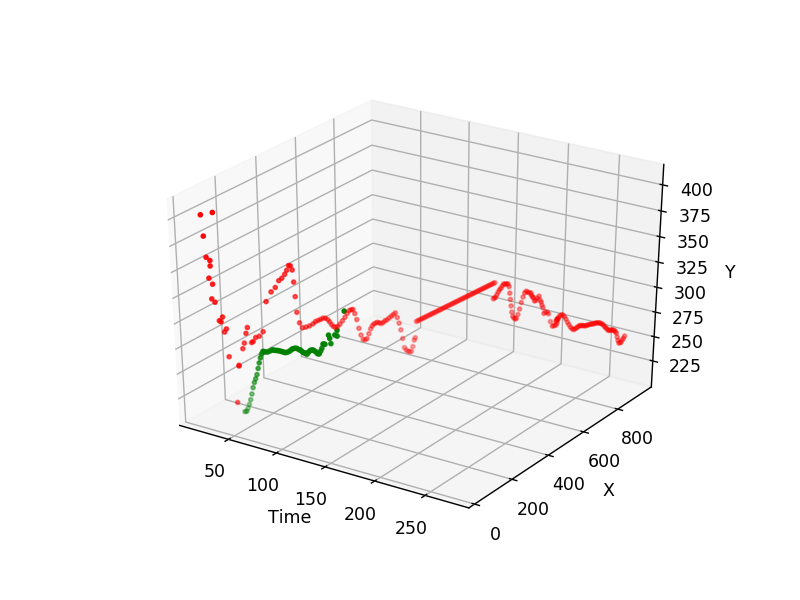

In [168]:
%matplotlib notebook
# Plotting tubes
def plotTubes(tubes, which = []):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    colors = ['r','g','b','c','m','y','k','xkcd:hot pink','xkcd:sand','xkcd:mint','xkcd:wine red']
    ax.set_xlabel('Time')
    ax.set_ylabel('X')
    ax.set_zlabel('Y')
    
    if not(which):
        for t in tubes:
            Ts = [e[0] for e in t]
            Xs = [e[1][0][0] for e in t]
            Ys = [e[1][0][1] for e in t]
            #Cs = t[0][3]
            ax.scatter(Ts,Xs,Ys,c=random.choice(colors), marker='.')

    else:
        for w in set(which):
            tubeToPlot = tubes[w]
            Ts = [e[0] for e in tubeToPlot]
            Xs = [e[1][0][0] for e in tubeToPlot]
            Ys = [e[1][0][1] for e in tubeToPlot]
            #Cs = [e[3] for e in tubeToPlot]
            ax.scatter(Ts,Xs,Ys,c=colors[which.index(w)], marker='.')
            
    plt.show()
        

plotTubes(tubes,which=[3,4])

In [169]:
# Using DBSCAN on each tube (ultimately want to create subtubes)

L=deepcopy(tubes)

labelList = []
for t in L:
    XforDB = np.array([[e[0],e[1][0][0], e[1][0][1]] for e in t])
    DBout = DBSCAN(eps=0.6*np.mean(AVGS), min_samples = 10).fit(XforDB)
    labelList.append(DBout.labels_)
    
#Populated labelList... now FIND OUT WHICH HAVE SUBTUBES AND PLOT THEM
#Thinking len(set()) > 2... but then the -1 thing smh idk
haveSubs = []
for t in labelList:
    labs = set(t)
    if -1 in labs:
        labs.remove(-1)
    if len(labs)>=2:
        haveSubs.append(labelList.index(t))
    

print(haveSubs)
#plotTubes(L, which = [13,14])
    

[2, 3, 5, 7, 10, 11, 13, 17, 21, 23]


C:\Users\khari\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [170]:
for t in labelList:
    labs = set(t)
    print(labs)
    if -1 in labs:
        labs.remove(-1)
    print(len(labs))
    print()
    

{0}
1

{0, -1}
1

{0, 1, -1}
2

{0, 1, 2, 3, -1}
4

{0}
1

{0, 1, -1}
2

{0}
1

{0, 1, -1}
2

{0}
1

{0, -1}
1

{0, 1, -1}
2

{0, 1, 2, -1}
3

{0}
1

{0, 1}
2

{0}
1

{0}
1

{0}
1

{0, 1, -1}
2

{0, -1}
1

{0}
1

{0}
1

{0, 1, -1}
2

{0}
1

{0, 1, -1}
2

{0}
1

{0}
1



In [171]:
DBtubes = deepcopy(tubes)
for t in range(0,len(DBtubes)):
    RGB0 = DBtubes[t][0][3]
    RGB1 = [random.randint(0,255), random.randint(0,255), random.randint(0,255)]
    RGB2 = [random.randint(0,255), random.randint(0,255), random.randint(0,255)]
    RGB3 = [random.randint(0,255), random.randint(0,255), random.randint(0,255)]
    RGB4 = [random.randint(0,255), random.randint(0,255), random.randint(0,255)]
    RGB5 = [random.randint(0,255), random.randint(0,255), random.randint(0,255)]
    RGBM1 = [0, 0, 255]
    
    for i in range(0,len(DBtubes[t])):
        if labelList[t][i]==0:
            DBtubes[t][i][3] = RGB0
        elif labelList[t][i]==1:
            DBtubes[t][i][3] = RGB1
        elif labelList[t][i]==2:
            DBtubes[t][i][3] = RGB2
        elif labelList[t][i]==3:
            DBtubes[t][i][3] = RGB3
        elif labelList[t][i]==4:
            DBtubes[t][i][3] = RGB4
        elif labelList[t][i]==5:
            DBtubes[t][i][3] = RGB5
        else:
            #print("You got too much dip on ya chip.")
            DBtubes[t][i][3] = RGBM1
    
    
putSomeTubesOnVid(DBtubes, vidbase+'_outstage9numsDBonly.mp4',which = haveSubs )
putTubesOnVid(DBtubes, vidbase+'_outstage9numsDBsubtubes.mp4', True)

FRAME 100 / 524
FRAME 200 / 524
FRAME 300 / 524
FRAME 400 / 524
FRAME 500 / 524
FRAME 100 / 524
FRAME 200 / 524
FRAME 300 / 524
FRAME 400 / 524
FRAME 500 / 524


In [69]:
haveSubs

[0, 2, 7, 8, 13, 14, 18, 19, 20]

In [ ]:
# Stage 9 Vibes-------------------------------------

#Sorting again... 
for t in tubes:
    t.sort(key = lambda x: x[0])

L = deepcopy(tubes)
tracks = []

for t in L:
    startf = t[0][0] + 3
    endf = t[-1][0] - 3
    starttrack = []
    endtrack = []
    
    if startf>10:
        #Do KCF tracking in front of this tube (till frame 10)
        startE = t[0]
        tracker = cv2.TrackerMedianFlow_create()
        bbox = getBoxFromEllipse(startE)
        ok = tracker.init(invid[int(startf)], bbox)
        starttrack.append((startf, bbox))
        k=1
        while ok and (startf-k > 10):
            ok, bbox = tracker.update(invid[int(startf-k)])
            if ok:
                starttrack.append((startf-k, bbox))
            k=k+1
                   
        
    if endf<(F-10):
        #Do KCF tracking at end of this tube (till frame F-10)
        startE = t[-1]
        tracker = cv2.TrackerMedianFlow_create()
        bbox = getBoxFromEllipse(startE)
        ok = tracker.init(invid[int(endf)], bbox)
        endtrack.append((endf, bbox))
        k=1
        while ok and (endf + k < F-10):
            ok, bbox = tracker.update(invid[int(endf+k)])
            if ok:
                endtrack.append((endf+k, bbox))
            k=k+1
            
    tracks.append(starttrack)
    tracks.append(endtrack)
    
    


In [ ]:
putTracksOnVid(tracks,vidbase+'_outstage8numsNEW.mp4',vidbase+'_outstage9MFtracks.mp4')


In [ ]:
print([e[0] for e in L[0]])

In [ ]:
tracks

In [ ]:
stage6tubes[6]

In [ ]:
tubes[3]


In [ ]:
#Creating a dictionary of information for each tube on the event list
eT = [e[-2] for e in EventList]
eT2= [e[-1] for e in EventList]
evTubes = set(eT + eT2)

evData = []
for tnum in evTubes:
    Ts = np.array([t[5] for t in tubeList if t[-1] == tnum])
    Xs = np.array([t[0] for t in tubeList if t[-1] == tnum])
    Ys = np.array([t[1] for t in tubeList if t[-1] == tnum])
    thisdict = {"tubenum": tnum, "Ts": Ts, "Xs": Xs, "Ys":Ys}
    evData.append(thisdict)

In [ ]:
newtubes = deepcopy(tubes)
for e in EventList:
    dict1 = [d for d in evData if d['tubenum']==e[-2]][0]
    dict2 = [d for d in evData if d['tubenum']==e[-1]][0]
    
    #Gather data from before the event...
    T1 = dict1['Ts'][np.where(dict1['Ts']<e[0]-1)]
    T2 = dict2['Ts'][np.where(dict2['Ts']<e[0]-1)]
    X1 = dict1['Xs'][np.where(dict1['Ts']<e[0]-1)]
    X2 = dict2['Xs'][np.where(dict2['Ts']<e[0]-1)]
    Y1 = dict1['Ys'][np.where(dict1['Ts']<e[0]-1)]
    Y2 = dict2['Ys'][np.where(dict2['Ts']<e[0]-1)]

    if len(T1)<10 or len(T2)<10: #not enough info to do best fit
        continue
    
    print(e[-2])
    print(e[-1])
    #Get best fit equations
    XofT1 = np.polyfit(T1,X1,1)
    YofT1 = np.polyfit(T1,Y1,1)
    XofT2 = np.polyfit(T2,X2,1)
    YofT2 = np.polyfit(T2,Y2,1)
    print("First x(t) =", XofT1[0],"t + ", XofT1[1])
    print("First y(t) =", YofT1[0],"t + ", YofT1[1])
    print("Second x(t) =",XofT2[0],"t + ", XofT2[1])
    print("Second y(t) =",YofT1[0],"t + ", YofT2[1])
    toAdd1 = []
    toAdd2 = []
    prev1 = [ell for ell in newtubes[e[-2]] if ell[0]==e[0]][0]
    prev2 = [ell for ell in newtubes[e[-1]] if ell[0]==e[0]][0]
    #next1 = [ell for ell in newtubes[e[-2]] if ell[0]==e[1]][0]
    #next2 = [ell for ell in newtubes[e[-1]] if ell[0]==e[1]-5][0]
    
    #Make ghost tubes based on the best fit equations
    for f in range(e[0],e[0]+60):
        X1 = XofT1[0] * f + XofT1[1]
        Y1 = YofT1[0] * f + YofT1[1]
        smax1 = prev1[1][1][0]
        bgax1 = prev1[1][1][1]
        phi1 = prev1[1][2]
        Vx1 = XofT1[0]
        Vy1 = YofT1[0]
        RGB = [0,0,255]
        newe1 = [f, ((X1,Y1), (smax1,bgax1), phi1), [Vx1,Vy1], RGB]
        toAdd1.append(newe1)
        if f == e[0]:
            print(newe1)
            
        
        X2 = XofT2[0] * f + XofT2[1]
        Y2 = YofT2[0] * f + YofT2[1]
        smax2 = prev2[1][1][0]
        bgax2 = prev2[1][1][1]
        phi2 = prev2[1][2]
        Vx2 = XofT2[0]
        Vy2 = YofT2[0]
        RGB = [0,0,255]
        newe2 = [f, ((X2,Y2), (smax2,bgax2), phi2), [Vx2,Vy2], RGB]
        toAdd2.append(newe2)
        
    print()
    newtubes[e[-2]].extend(toAdd1)
    newtubes[e[-1]].extend(toAdd2)
    
        


In [ ]:
stage8tubes = newtubes
putTubesOnVid(newtubes, vidbase+'_outstage8quad_last30.mp4')

In [ ]:
newtubes = deepcopy(tubes)
for e in EventList:
    dict1 = [d for d in evData if d['tubenum']==e[-2]][0]
    dict2 = [d for d in evData if d['tubenum']==e[-1]][0]
    
    #Gather data from before the event...
    T1 = dict1['Ts'][np.where(dict1['Ts']<e[0])]
    T2 = dict2['Ts'][np.where(dict2['Ts']<e[0])]
    X1 = dict1['Xs'][np.where(dict1['Ts']<e[0])]
    X2 = dict2['Xs'][np.where(dict2['Ts']<e[0])]
    Y1 = dict1['Ys'][np.where(dict1['Ts']<e[0])]
    Y2 = dict2['Ys'][np.where(dict2['Ts']<e[0])]

    if len(T1)<10 or len(T2)<10: #not enough info to do best fit
        continue
    
    print(e[-2])
    print(e[-1])
    #Get best fit equations
    XofT1 = np.polyfit(T1[-30:],X1[-30:],2)
    YofT1 = np.polyfit(T1[-30:],Y1[-30:],2)
    XofT2 = np.polyfit(T2[-30:],X2[-30:],2)
    YofT2 = np.polyfit(T2[-30:],Y2[-30:],2)
    print("First x(t) =", XofT1[0],"t^2 + ", XofT1[1],"t", + XofT1[2])
    print("First y(t) =", YofT1[0],"t^2 + ", YofT1[1],"t", + YofT1[2])
    print("Second x(t) =",XofT2[0],"t^2 + ", XofT2[1],"t", + XofT2[2])
    print("Second y(t) =",YofT2[0],"t^2 + ", YofT2[1],"t", + YofT2[2])
    print()
    toAdd1 = []
    toAdd2 = []
    prev1 = [ell for ell in newtubes[e[-2]] if ell[0]==e[0]-10][0]
    prev2 = [ell for ell in newtubes[e[-1]] if ell[0]==e[0]-10][0]

    #Make ghost tubes based on the best fit equations
    for f in range(e[0],e[0]+60):
        X1 = (XofT1[0] * f**2) + (XofT1[1]*f) + XofT1[2]
        Y1 = (YofT1[0] * f**2) + (YofT1[1]*f) + YofT1[2]
        smax1 = prev1[1][1][0]
        bgax1 = prev1[1][1][1]
        phi1 = prev1[1][2]
        Vx1 = XofT1[0]
        Vy1 = YofT1[0]
        RGB = [0,0,255]
        newe1 = [f, ((X1,Y1), (smax1,bgax1), phi1), [Vx1,Vy1], RGB]
        toAdd1.append(newe1)
        if f == e[0]:
            print(newe1)
        
        X2 = (XofT2[0] * f**2) + (XofT2[1]*f) + XofT2[2]
        Y2 = (YofT2[0] * f**2) + (YofT2[1]*f) + YofT2[2]
        smax2 = prev2[1][1][0]
        bgax2 = prev2[1][1][1]
        phi2 = prev2[1][2]
        Vx2 = XofT2[0]
        Vy2 = YofT2[0]
        RGB = [0,0,255]
        newe2 = [f, ((X2,Y2), (smax2,bgax2), phi2), [Vx2,Vy2], RGB]
        toAdd2.append(newe2)
    
    newtubes[e[-2]].extend(toAdd1)
    newtubes[e[-1]].extend(toAdd2)
    
        


In [ ]:
print(T1[-30:])